In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys
from glob import glob
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter
import h5py
import quantities as pq

sys.path.append('../scripts/')
from LPA import LPA_Signal

sys.path.append('../scripts/icsd_scripts/')
from data_processing_before_lpa import *

%config Completer.use_jedi = False

In [6]:
sim_data_dir = '/Users/atleeskelandrimehaug/Dropbox (Simula)/Data/output_sims'
fig_dir = 'Figures/test_notebooks'

In [7]:
# for plotting
plt.rcParams.update({'font.size': 16})

## Load simulation data

In [8]:
nchan_sim = 26                                          # Number of channels on probe in simulation

trial_dur_sim = 750                                     # Duration one trial (ms)
tstim_onset_sim = 250
tstim_onset_sim_dg = 500
trial_dur_sim_dg = 3000
ntrials_sim = 10                                        # Number of trials
t_rem_trial_start = 50

trial_dur_sim_corr = trial_dur_sim-t_rem_trial_start
trial_dur_sim_dg_corr = 3000-t_rem_trial_start
tstim_onset_sim = tstim_onset_sim-t_rem_trial_start
tstim_onset_sim_dg = tstim_onset_sim_dg-t_rem_trial_start

channel = np.arange(nchan_sim)

In [9]:
sim_data_dir = '../data/sim_data/'

selected_sims_data_dir = os.path.join(sim_data_dir, '*full_model*')

### Spikes

- Load population spike trains from sims with different stimuli

In [19]:
timestamps_all_stim = dict()

#### Flashes

In [20]:
timestamps_configs = find_all_fir_rates_files_sim(selected_sims_data_dir.rsplit('/', 1)[0], 'timestamps_with_neuron_ids*.npy')
sim_names = list(timestamps_configs.keys())
print(sim_names)
sim_name = sim_names[-1]

['full_model_white_flash', 'full_model_black_flash']


#### Compute population firing rates

In [53]:
npop_guess = 5

In [55]:
sims_spike_trains_cell_pops = timestamps_to_spiketrains_sim(timestamps_configs, mode = 'only_exc_except_L1')


 full_model_white_flash
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
Use only excitatory cells except for L1. Skip.
i23Pvalb
Use only excitatory cells except for L1. Skip.
i23Sst
Use only excitatory cells except for L1. Skip.
i4Htr3a
Use only excitatory cells except for L1. Skip.
i4Pvalb
Use only excitatory cells except for L1. Skip.
i4Sst
Use only excitatory cells except for L1. Skip.
i5Htr3a
Use only excitatory cells except for L1. Skip.
i5Pvalb
Use only excitatory cells except for L1. Skip.
i5Sst
Use only excitatory cells except for L1. Skip.
i6Htr3a
Use only excitatory cells except for L1. Skip.
i6Pvalb
Use only excitatory cells except for L1. Skip.
i6Sst
Use only excitatory cells except for L1. Skip.

 full_model_black_flash
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
Use only excitatory cells except for L1. Skip.
i23Pvalb
Use only excitatory cells except for L1. Skip.
i23Sst
Use only excitatory cells except

In [56]:
sims_spike_trains_layer_pops = spiketrains_by_layer(sims_spike_trains_cell_pops, npop_guess = npop_guess)

full_model_white_flash
e23Cux2 12689
e4Nr5a1 1248
e4Rorb 2605
e4Scnn1a 3072
e4other 3329
e5Rbp4 6010
e5noRbp4 1559
e6Ntsr1 12882
i1Htr3a 999
full_model_black_flash
e23Cux2 12689
e4Nr5a1 1248
e4Rorb 2605
e4Scnn1a 3072
e4other 3329
e5Rbp4 6010
e5noRbp4 1559
e6Ntsr1 12882
i1Htr3a 999


In [57]:
sims_spike_trains_layer_pops[sim_name].keys()

dict_keys(['L1', 'L2/3', 'L4', 'L5', 'L6'])

In [58]:
fir_rate_all_trials = dict()
fir_rate_trial_avg = dict()

fir_rate_trial_avg_pops_temp = np.zeros((len(sims_spike_trains_layer_pops.keys()), npop_guess, 700))
for isim, sim_name in enumerate(sims_spike_trains_layer_pops.keys()):
    print(sim_name)
    for ipop, pop_name in enumerate(sims_spike_trains_layer_pops[sim_name].keys()):
        print(pop_name)
        fir_rate_temp = np.mean(np.mean(sims_spike_trains_layer_pops[sim_name]\
                                            [pop_name][:,:,t_rem_trial_start:], axis = 0), axis = 0)
        
        fir_rate_trial_avg_pops_temp[isim, ipop] = fir_rate_temp
        

for ipop, pop_name in enumerate(sims_spike_trains_layer_pops[sim_name].keys()):
    print(pop_name)
    fir_rate_trial_avg[pop_name] = fir_rate_trial_avg_pops_temp[:, ipop]
    
fir_rate_all_stim_trial_avg = fir_rate_trial_avg

full_model_white_flash
L1
L2/3
L4
L5
L6
full_model_black_flash
L1
L2/3
L4
L5
L6
L1
L2/3
L4
L5
L6


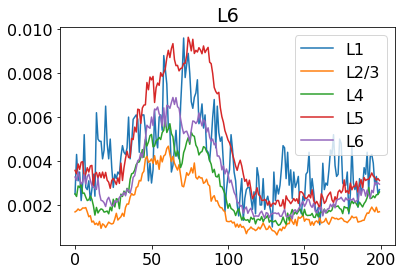

In [59]:
isim = 0
plt.figure()
for pop_name in fir_rate_all_stim_trial_avg.keys():
    #for isim in range(fir_rate_all_stim_trial_avg[pop_name].shape[0]):
        

    plt.plot(fir_rate_all_stim_trial_avg[pop_name][isim][tstim_onset_sim:tstim_onset_sim+200], label = pop_name)

    plt.title(pop_name)
plt.legend()

## Load data from application of LPA

In [60]:
loadpath = '../make_figures_article/lpa_results_data/test_notebooks'

filename = 'lpa_results_applied_to_full_model_sim_w_'+str(npop_guess)+'_pop.npy'

loadpath = os.path.join(loadpath,filename)

lpa_results = np.load(loadpath, allow_pickle = True)[()]

In [61]:
# LPA-estimated MUA
Mphi_lpa = lpa_results['Mphi_lpa']

# Est. temporal profiles of population firing rates
Mmat_lpa = lpa_results['Mmat_lpa']

# Est. spatial profiles of laminar populations
rmat_lpa = lpa_results['rmat_lpa']

In [62]:
layer_borders = np.array([0, 100, 310, 430, 650, 850])

In [63]:
hitmonchan = ['#0f0f0f', '#ccb37a', '#a38a72', '#c4b3c4', '#59400f', '#bc3049', '#edd49b', '#a39ba3', '#614972', '#e56149', '#8a1f00', '#fe9359', '#fef5fe', '#ddccdd']
magneton = ['#383030', '#0f0f0f', '#8ab3a3', '#d4f5dd', '#514949', '#fefefe', '#8a8a8a', '#598261', '#b3d4bc', '#fe8a49', '#51ccf5', '#ed1700', '#2882ab', '#b3b3b3', '#d4d4d4']

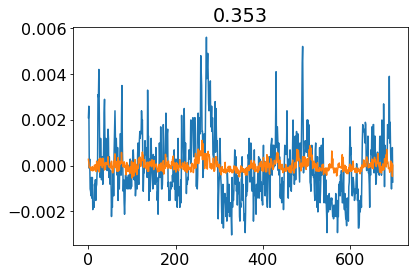

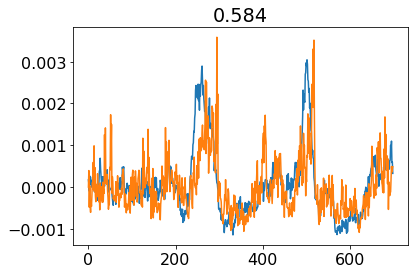

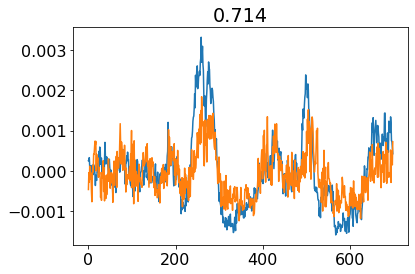

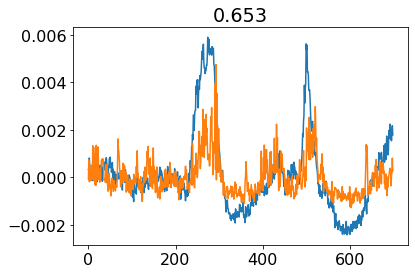

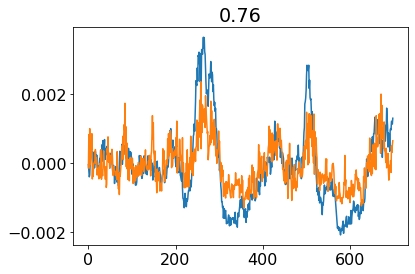

In [69]:
istim = 0
for ipop in range(np.array(list(fir_rate_all_stim_trial_avg.values())).shape[0]):
    fir_rate_plot_test = np.array(list(fir_rate_all_stim_trial_avg.values()))[ipop, istim].copy()
    
    norm_val = np.array(list(fir_rate_all_stim_trial_avg.values()))[:, istim].copy().max()
    
    #fir_rate_plot_test = fir_rate_plot_test/norm_val
    
    fir_rate_plot_test -= np.mean(fir_rate_plot_test[:tstim_onset_sim])
    
    rmat_lpa_plot_test = rmat_lpa[istim, :, ipop]-np.mean(rmat_lpa[istim,:tstim_onset_sim,ipop])
    
    plt.figure()
    
    plt.plot(fir_rate_plot_test)
    plt.plot(rmat_lpa_plot_test)
    
    plt.title(str(np.round(np.corrcoef(fir_rate_plot_test, rmat_lpa_plot_test)[0,1],3)))

In [83]:
ntime = 700

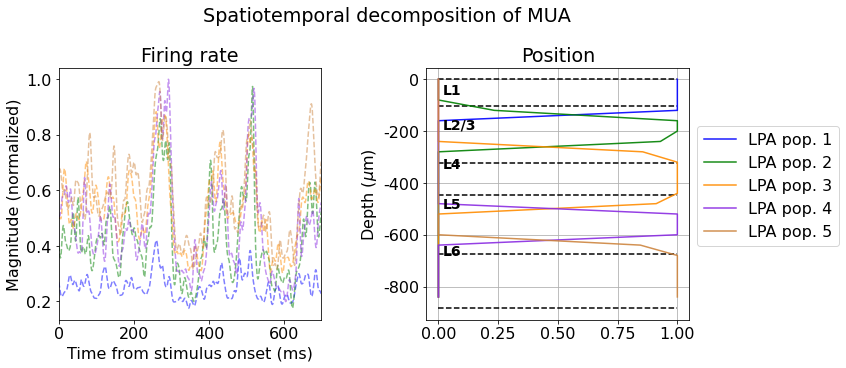

In [84]:
fig, ax = plt.subplots(ncols = 2, nrows =1, figsize = (12, 5))

fig.subplots_adjust(wspace = 0.4, left = 0.07, right = 0.8, bottom = 0.12, top = 0.82)

t = np.arange(ntime)
channel = np.arange(nchan)
istim = 0

for i in range(npop_guess):
    fir_rate_lpa_plot = rmat_lpa[istim,:,i]#[:,stim_onset_mark:stim_onset_mark+100,i]#/rmat_lpa[:,stim_onset_mark:stim_onset_mark+100,:].max()
    #fir_rate_lpa_plot = np.mean(fir_rate_lpa_plot, axis = 0)
    fir_rate_lpa_plot = gaussian_filter1d(fir_rate_lpa_plot,sigma = 3)
    fir_rate_lpa_plot = fir_rate_lpa_plot/gaussian_filter(rmat_lpa[0,:,:], sigma = (3,0)).max()
    ax[0].plot(fir_rate_lpa_plot, '--', color = pop_colors[i], alpha=0.5, label='LPA estimate')
    #ax[i,0].plot(t, MUA_time[i]*1E3, alpha=0.5, label='ground truth')
    ax[0].set_xlabel('Time from stimulus onset (ms)')
    ax[0].set_ylabel('Magnitude (normalized)')
    #ax[1,0].set_ylabel('Magnitude (a. u.)')
    
    ax[1].plot(Mmat_lpa[:,i], channel, alpha=0.9, color = pop_colors[i], label='LPA pop. '+str(i+1))
    #ax[i,1].plot(M[i], channel, alpha=0.5, label='ground truth')
    ax[1].set_ylabel('Channel')
    ax[1].grid()
    
    ax[0].set_title('Firing rate')
    ax[1].set_title('Position')
    

ax[0].margins(x=0)
    
ax[1].invert_yaxis()
ax[1].legend(bbox_to_anchor = (1,0.8))

ax[1].set_ylabel('Depth ($\mu$m)')
ax[1].set_yticks(np.arange(0,25+5,5))
ax[1].set_yticklabels(-np.arange(0,1000+200,200))

#ax[0].set_xticks(np.arange(0,100+20,20))

fig.suptitle('Spatiotemporal decomposition of MUA', y = 0.99, x = 0.45)

for ilayer, border in enumerate(layer_borders):
    ax[1].hlines(y = border/1000*nchan_sim, xmin = 0, xmax = 1, linestyle = '--')
    
plt.figtext(x = 0.515, y = 0.745, s = 'L1', fontsize = 14, fontweight = 560)
plt.figtext(x = 0.515, y = 0.65, s = 'L2/3', fontsize = 14, fontweight = 560)
plt.figtext(x = 0.515, y = 0.54, s = 'L4', fontsize = 14, fontweight = 560)
plt.figtext(x = 0.515, y = 0.43, s = 'L5', fontsize = 14, fontweight = 560)
plt.figtext(x = 0.515, y = 0.3, s = 'L6', fontsize = 14, fontweight = 560)

fig_name = 'mua_decomp_temp_and_spat_profiles_together_mua_'+baseline_string+'.png'
savepath = os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops', fig_name)
#fig.savefig(savepath, facecolor = 'w')

In [77]:
nchan = 22
nchan_lim = nchan

In [78]:
subtract_baseline = False
baseline_presubtracted = False
if subtract_baseline:
    baseline_end = 200
    baseline_string = 'no_baseline'
else:
    baseline_end = 0
    if baseline_presubtracted:
        baseline_string = 'baseline_pre_subtracted'
    else:
        baseline_string = 'w_baseline'
        
baseline_string

'w_baseline'

NameError: name 'MUA' is not defined

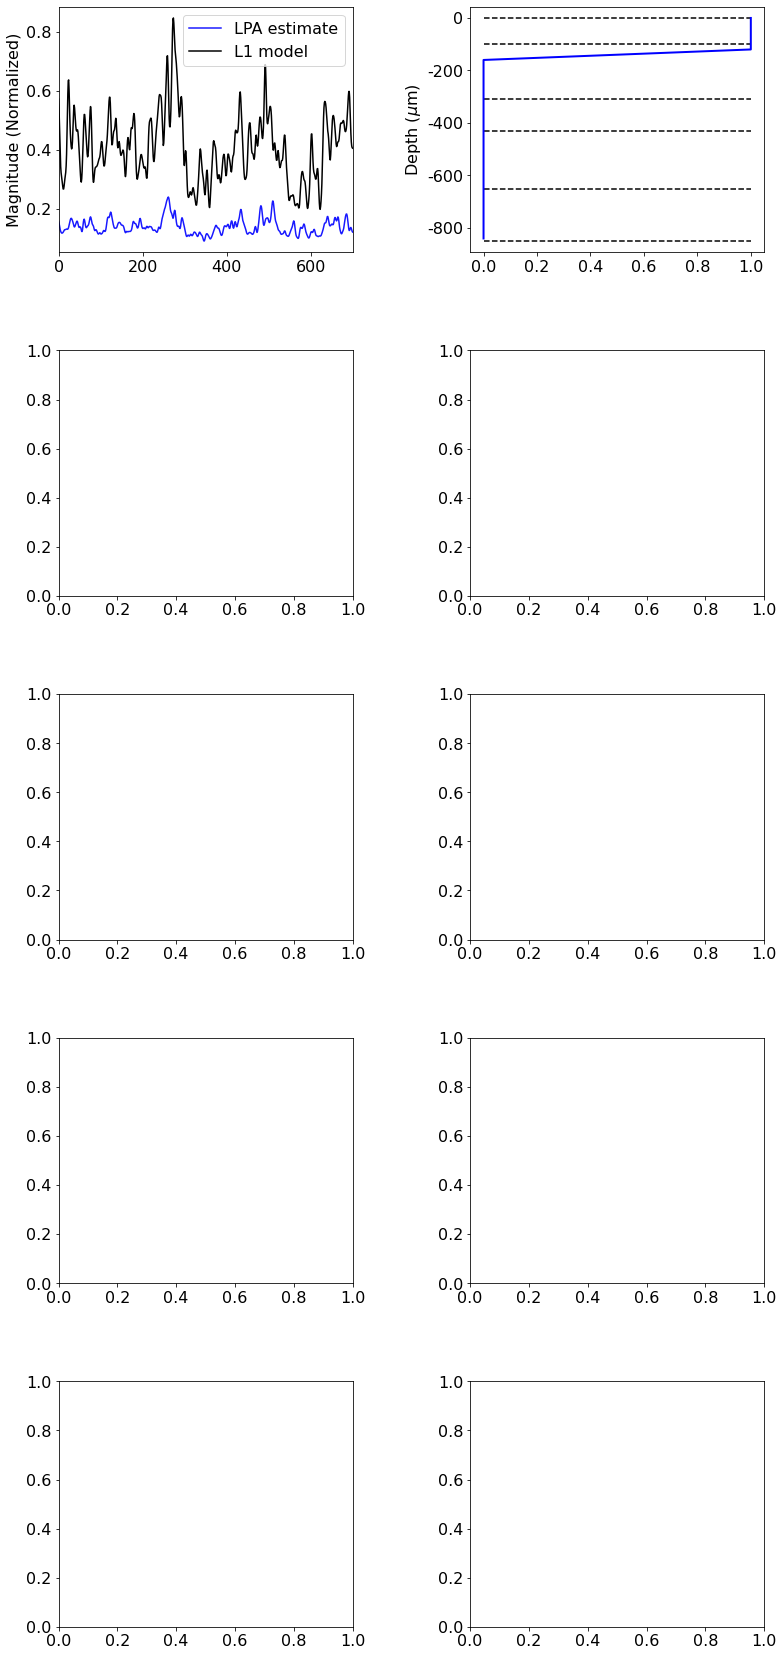

In [79]:
fig, ax = plt.subplots(ncols = 2, nrows =np.max([npop_guess,2]), figsize = (14, 5*np.max([npop_guess,2])))

fig.subplots_adjust(hspace = 0.4, wspace = 0.4, left = 0.1, right = 0.8, bottom = 0.05, top = 0.95)

t = np.arange(rmat_lpa.shape[1])
channel = np.arange(nchan)
sigma = 2

istim = 0

pop_colors = ['b', 'g', 'darkorange', 'blueviolet', 'peru']
pop_colors_w_lgn = ['lime', 'b', 'g', 'darkorange', 'blueviolet', 'peru']
for i, layer_pop_name in zip(range(npop_guess), list(fir_rate_all_stim_trial_avg.keys())):
    fir_rate_lpa_plot = rmat_lpa[istim,:,i]/rmat_lpa[istim].max()
    fir_rate_lpa_plot = gaussian_filter1d(fir_rate_lpa_plot, sigma = sigma)
    ax[i,0].plot(t, fir_rate_lpa_plot, color = pop_colors[i], alpha=0.9, label='LPA estimate')
    
    fir_rate_all_stim_plot = fir_rate_all_stim_trial_avg[layer_pop_name].copy()
    fir_rate_stim_plot = fir_rate_all_stim_plot[istim]
    
    norm_val = np.array(list(fir_rate_all_stim_trial_avg.values()))[:, istim].copy().max()
    
    if 'no_baseline' in baseline_string:
        fir_rate_stim_plot -= np.mean(fir_rate_stim_plot[:tstim_onset_sim])
    
    #fir_rate_layerpop = np.mean(np.mean(sim_spike_trains_layer_pops, axis = 0), axis = 0)
    #if subtract_baseline or baseline_presubtracted:
        #fir_rate_layerpop -= np.mean(fir_rate_layerpop[:tstim_onset_sim])
    
    fir_rate_stim_plot = fir_rate_stim_plot/norm_val
    #fir_rate_stim_plot = fir_rate_stim_plot#[t_start:t_stop]#-np.mean(fir_rate_layerpop[:tstim_onset_sim])
    fir_rate_stim_plot = gaussian_filter1d(fir_rate_stim_plot, sigma = sigma)
    ax[i,0].plot(fir_rate_stim_plot, color = 'k', label = layer_pop_name+' model')
    
    ax[i,0].margins(x=0)
    if i == npop_guess-1:
        ax[i,0].set_xlabel('Time from stimulus onset (ms)')
    ax[i,0].set_ylabel('Magnitude (Normalized)')
    #ax[i,0].set_ylim([-0.0,1])
    
    ax[i,0].legend()
    
    ax[i,1].plot(Mmat_lpa[:,i], channel, lw = 2, alpha=1, label='LPA estimate', color = pop_colors[i])
    ax[i,1].invert_yaxis()
    ax[i,1].set_ylabel('Depth ($\mu$m)')
    ax[i,1].set_yticks(np.arange(0,nchan_lim+5, 5))
    ax[i,1].set_yticklabels(-np.arange(0,1000,200))
    #ax[i,1].grid()
    
    for ilayer, border in enumerate(layer_borders):
        ax[i,1].hlines(y = border/1000*(nchan_sim-1), xmin = 0, xmax = 1, linestyle = '--')
        
    mua_power = np.mean(MUA[istim, t_start:t_stop], axis = 0)
    mua_power_plot = mua_power/mua_power.max()
    
    #ax[i, 1].plot(mua_power_plot, channel, magneton[10], alpha = 0.8, label = 'MUA power')
    ax[i,1].legend(bbox_to_anchor = (1, 0.9))
    
    
    mua_power = np.mean(MUA[istim], axis = 0)
    mua_power_plot = mua_power/mua_power.max()
    
    ax[i, 1].plot(mua_power_plot, channel, 'olive', alpha = 0.8, label = 'MUA power')
    ax[i,1].legend(bbox_to_anchor = (1, 0.9))
    
    yshift = i*0.192-i*i*0.00009
    plt.figtext(x = 0.53, y = 0.935-yshift, s = 'L1', fontsize = 14, fontweight = 560)
    plt.figtext(x = 0.53, y = 0.913-yshift, s = 'L2/3', fontsize = 14, fontweight = 560)
    plt.figtext(x = 0.53, y = 0.888-yshift, s = 'L4', fontsize = 14, fontweight = 560)
    plt.figtext(x = 0.53, y = 0.862-yshift, s = 'L5', fontsize = 14, fontweight = 560)
    plt.figtext(x = 0.53, y = 0.832-yshift, s = 'L6', fontsize = 14, fontweight = 560)
    
    #plt.figtext(x=0.3, y = 0.7-yshift, s = 'Stim.\noffset')
    
    ax[i,0].set_title('Firing rate of population '+str(i+1))
    ax[i,1].set_title('Position of population '+str(i+1))
    
fig_name = 'mua_decomp_mua_'+baseline_string+'_both_flash.png'

savepath = fig_dir

if not os.path.exists(savepath):
    os.mkdir(savepath)

'''savepath = os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops', fig_name)

if not os.path.exists(os.path.join(fig_dir, baseline_string)):
    os.mkdir(os.path.join(fig_dir, baseline_string))

if not os.path.exists(os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops')):
    os.mkdir(os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops'))'''

#fig.savefig(savepath, facecolor = 'w')